## Installing / loading the libraries 

In [1]:
#loading in the packages 
import pickle 
import pandas as pd
import random
import numpy as np

# LDA
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Visualizations
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

c:\Users\wlibe\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## loading the dataset that was cleaned in a separate file

In [2]:
#opening the pickle file 
with open("articles_cleaned.pkl", "rb") as file:
    articels = pickle.load(file)

In [3]:
articels['cleaned_article']

0       [midden, mali, mopti-regio, wapenen, man, burg...
1       [spaans, politie, weekend, afrikaans, migrant,...
2       [situatie, boord, vluchtelingenschip, sea-watc...
3       [braziliaans, hoofdstad, brasilia, uiterst, re...
4       [nasa, nieuw, signaal, binnengekrijgen, ruimte...
                              ...                        
1025    [kort, supernova","op, nieuw, detailleren, fot...
1026    [turkije, minstens, dood, geval, overstroming,...
1027    [twee, rij, hevig, onlust, huis, pakistaans, o...
1028    [goedemorgen, ruim, nederlands, kiezer, stembu...
1029    [dodental, ongeluk, veerboot, gabon, donderdag...
Name: cleaned_article, Length: 22591, dtype: object

In [4]:
#from list to string using the apply function for climate titles 
articels.loc[:,'cleaned_article_1'] = articels['cleaned_article'].apply(lambda x: ' '.join(x))


In [5]:
#Get tokenized texts for title and paragraph in both climate and farmer 
tokenized = articels['cleaned_article_1'].values.tolist()
tokenized 


["midden mali mopti-regio wapenen man burger doden onbekend aantal mens raken gewond huis brand steken pers_bureau afp slachtoffer lid fulani-volk dader donzo-jagers bekend dozo's juni verantwoordelijk dood fulani mali honderd dood geval etnisch geweld divers nomadenvolk volk strijden toegang water land moslimextremisten actief mali graag gebruik probleem volk geweld creëren",
 'spaans politie weekend afrikaans migrant gesnapt uitgeholde matrasis grens probeerden filmp guardia civil betrappen matrasis lagen auto spaans enclave melilla proberen politie voertuig do_orzoeken nemen bestuurder been agent matrasis op_ensneden doken migranten euro betalen mensensmokkelaar spanje vervoeren man migrantendetentie zetten vn migrant melilla',
 "situatie boord vluchtelingenschip sea-watch middellandse zee nijpend dreigen gebrek drin_kwater voedsel schip liggen storm woordvoerder jelle goezinnen sea-watch nederlands vlag varen liggen elf dag zee wachten schip haven varen goezinnen zitten vluchteling

## Number of topics based on the coherence 

In [6]:
def prepareForLDA(list_tokenized, stopwords = []):
    """
    Prepares a dictionary and a corpus for LDA
    Parameters:
        - list_tokenized: a list of tokenized documents (i.e. a list of lists of tokens)
        - stopwords: words that still need to be excluded from the list_tokenized
    """
    # make a new list_tokenized without the stopwords
    list_stopwordsExcluded = []

    for doc in list_tokenized:
        list_stopwordsExcluded.append([word for word in doc if word not in stopwords])

    dictionary = Dictionary(list_stopwordsExcluded) # get the vocabulary

    corpus = [dictionary.doc2bow(text) for text in list_stopwordsExcluded]

    return list_stopwordsExcluded, dictionary, corpus

In [8]:
#Function for calculating coherence scores
def trainLDAModels(dictionary, corpus, texts, limit, start, step):
    """
    Trains LDA Models with n_topics ranging from start to limit (included).
    Parameters:
        - dictionary - gensim.corpora.dictionary.Dictionary containing all vocabulary
        - corpus - list created using dictionary.doc2bow(tokenizedText)
        - texts - tokenized list
        - limit - maximum number of topics
        - start - minimum number of topics
        - step - step to increase number of topics in loop
        - doc_topic_prior - alpha to be used in ldaModel
        - learning_decay - to be used in ldaModel
        - topic_word_prior - eta to be used in ldaModel

    Returns:
        - A list of trained LDA Models
        - A list of coherence values pertaining to those models

    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit+1, step):
        print('Calculating for',num_topics,'topics')
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)

        #You can adjust the method for coherence here (replace 'c_v' with any other method from the list above)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [13]:
start = 100
limit = 301
step = 50

In [9]:
#Visualise the coherence scores in a plot - there a various ways to create graphs in Python, below we use matplotlib (https://matplotlib.org)

def checkCoherence(coherenceValues, start = start, limit = limit, step = step):
    x = range(start, limit + 1, step)
    plt.figure(figsize=(8,8))
    plt.plot(x, coherenceValues + [0]*(len(x) - len(coherenceValues)))
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherenceValues"), loc='best')
    plt.vlines(x[np.argmax(coherenceValues)], plt.ylim()[0], plt.ylim()[1],linestyles='dashed')
    plt.show()

    #list the coherence scores
    for m, cv in zip(x, coherenceValues):   
        print("Num Topics =", m, " has a Coherence Value of", round(cv, 4))

In [10]:
def showWordsPerTopic(model, n_words):
    topicWords = model.show_topics(num_topics = -1, num_words = n_words, formatted=False)
    for topic in topicWords:
        wordList = [word[0] for word in topic[1]]
        wordList = ', '.join(wordList)
        print('Topic {}: {}'.format(str(topic[0]), wordList))


In [31]:
#Here the previously found optimal values for alpha, beta and learning decay are used. 
tokenized_a, dictionary, corpus = prepareForLDA(articels.cleaned_article, tokenized)


KeyboardInterrupt: 

In [18]:
modelList, coherenceValues = trainLDAModels(dictionary = dictionary, corpus = corpus, texts = tokenized_a, start=start, limit=limit, step=step)

Calculating for 100 topics
Calculating for 150 topics
Calculating for 200 topics
Calculating for 250 topics
Calculating for 300 topics


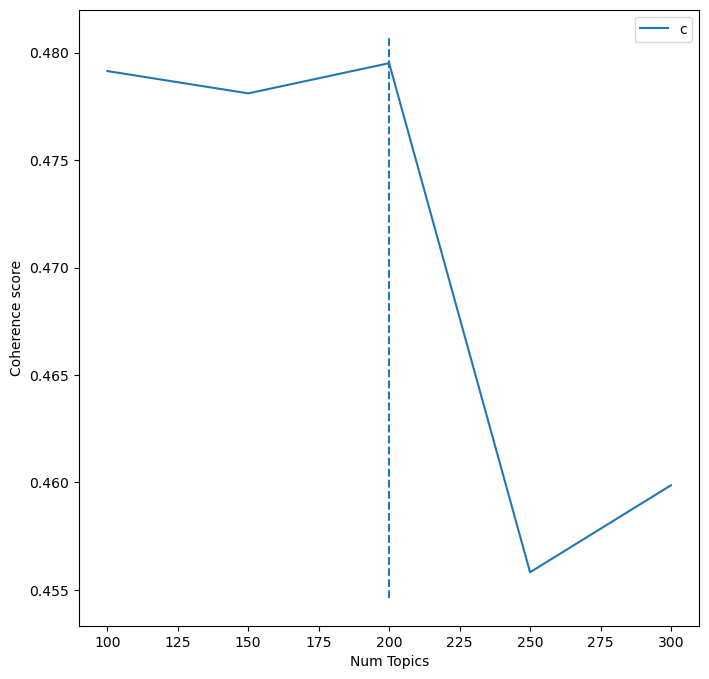

Num Topics = 100  has a Coherence Value of 0.4791
Num Topics = 150  has a Coherence Value of 0.4781
Num Topics = 200  has a Coherence Value of 0.4795
Num Topics = 250  has a Coherence Value of 0.4558
Num Topics = 300  has a Coherence Value of 0.4599


In [19]:
checkCoherence(coherenceValues)

In [20]:
# save models as pickle file
with open('LDA_modelList_100_300.pkl', 'wb') as file:
    pickle.dump(modelList, file)

In [27]:
start = 50 
limit = 300
step = 25

In [32]:
#Here the previously found optimal values for alpha, beta and learning decay are used. 
tokenized_a, dictionary, corpus = prepareForLDA(articels.cleaned_article, tokenized)

In [33]:
modelList, coherenceValues = trainLDAModels(dictionary = dictionary, corpus = corpus, texts = tokenized_a, start=start, limit=limit, step=step)

Calculating for 50 topics
Calculating for 75 topics
Calculating for 100 topics
Calculating for 125 topics
Calculating for 150 topics
Calculating for 175 topics
Calculating for 200 topics
Calculating for 225 topics
Calculating for 250 topics
Calculating for 275 topics
Calculating for 300 topics


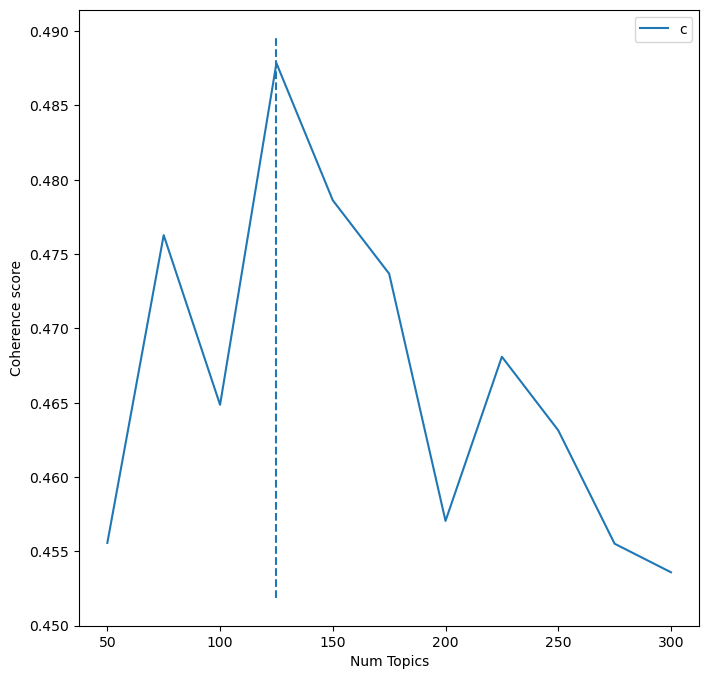

Num Topics = 50  has a Coherence Value of 0.4556
Num Topics = 75  has a Coherence Value of 0.4763
Num Topics = 100  has a Coherence Value of 0.4649
Num Topics = 125  has a Coherence Value of 0.4878
Num Topics = 150  has a Coherence Value of 0.4786
Num Topics = 175  has a Coherence Value of 0.4737
Num Topics = 200  has a Coherence Value of 0.4571
Num Topics = 225  has a Coherence Value of 0.4681
Num Topics = 250  has a Coherence Value of 0.4631
Num Topics = 275  has a Coherence Value of 0.4555
Num Topics = 300  has a Coherence Value of 0.4536


In [34]:
checkCoherence(coherenceValues)

In [35]:
# save models as pickle file
with open('LDA_modelList_50_300_by_25.pkl', 'wb') as file:
    pickle.dump(modelList, file)

#printing the number of topis 

In [37]:
with open('LDA_modelList_50_300_by_25.pkl', 'rb') as file:
    lda = pickle.load(file)

In [39]:
for model in modelList[:135]:
    topics = model.show_topics(num_topics=1, num_words=20)
    for topic in topics:
        print(f"Top 20 words for topic {topic[0]}: {topic[1]}")
    print('\n')

Top 20 words for topic 31: 0.023*"turkije" + 0.022*"land" + 0.012*"zaken" + 0.011*"turks" + 0.011*"militair" + 0.011*"minister" + 0.011*"president" + 0.010*"buitenlandse" + 0.009*"syrië" + 0.009*"grens" + 0.008*"ministerie" + 0.007*"oorlog" + 0.007*"rusland" + 0.007*"amerikaans" + 0.007*"invasie" + 0.007*"nederland" + 0.006*"defensie" + 0.006*"regering" + 0.006*"erdogan" + 0.006*"navo"


Top 20 words for topic 16: 0.030*"santokhi" + 0.014*"asml" + 0.014*"dubai" + 0.013*"li" + 0.013*"bangladesh" + 0.010*"bouterse" + 0.009*"paramaribo" + 0.009*"b." + 0.008*"goederentrein" + 0.008*"ziekenhuis" + 0.007*"mens" + 0.007*"treinongeluk" + 0.006*"reiziger" + 0.006*"china" + 0.006*"apotheek" + 0.005*"voorste" + 0.005*"melden" + 0.005*"chinees" + 0.005*"blijven" + 0.005*"getest"


Top 20 words for topic 17: 0.062*"schiet_partij" + 0.046*"india" + 0.033*"indiase" + 0.031*"executie" + 0.028*"rwanda" + 0.017*"paulo" + 0.016*"são" + 0.016*"modi" + 0.014*"22_jarig" + 0.013*"deelstaat" + 0.013*"schutter

In [40]:
for model in modelList:
    showWordsPerTopic(model, 20)
    print('\n')

Topic 0: bestorming, zweden, zweeds, scholz, litouwen, deen, greenpeace, duitsland, krijgen, slowakije, dubai, duits, milieuorganisatie, nederland, festival, aard_gas, reiziger, estland, land, reisadvie
Topic 1: japan, japans, mens, santokhi, nieuw, groot, abe, georgia, blijven, partij, land, krijgen, zitten, tijd, leven, stad, veel, mexico, jaar, johannes
Topic 2: rechter, hof, uitspraak, zaak, minister, nederland, krijgen, rechtbank, veroordelen, myanmar, justitie, beroep, nederlands, straf, stellen, hooggerechtshof, cel, land, besluit, hoog
Topic 3: land, sanctie, vs, nucleair, akkoord, president, verenigde, iran, amerikaans, staten, reservist, kernwapen, minister, economisch, garde, ontbossing, nieuw, deal, internationaal, revolutionaire
Topic 4: miljard, euro, dollar, geld, kern_centrale, reactor, betalen, belasting, fonds, rijk, bedrag, vermogen, inspectie, centraal, shell, radioactief, horeca, roebel, compensatie, egypte
Topic 5: belgisch, belgië, australisch, australië, vlaams,

In [ ]:
for model in modelList:
    showWordsPerTopic(model, 20)
    print('\n')

In [7]:
start = 15 
limit = 30
step =  5

In [11]:
#Here the previously found optimal values for alpha, beta and learning decay are used. 
tokenized_a, dictionary, corpus = prepareForLDA(articels.cleaned_article, tokenized)


In [12]:
modelList, coherenceValues = trainLDAModels(dictionary = dictionary, corpus = corpus, texts = tokenized_a, start=start, limit=limit, step=step)

Calculating for 15 topics
Calculating for 20 topics
Calculating for 25 topics
Calculating for 30 topics


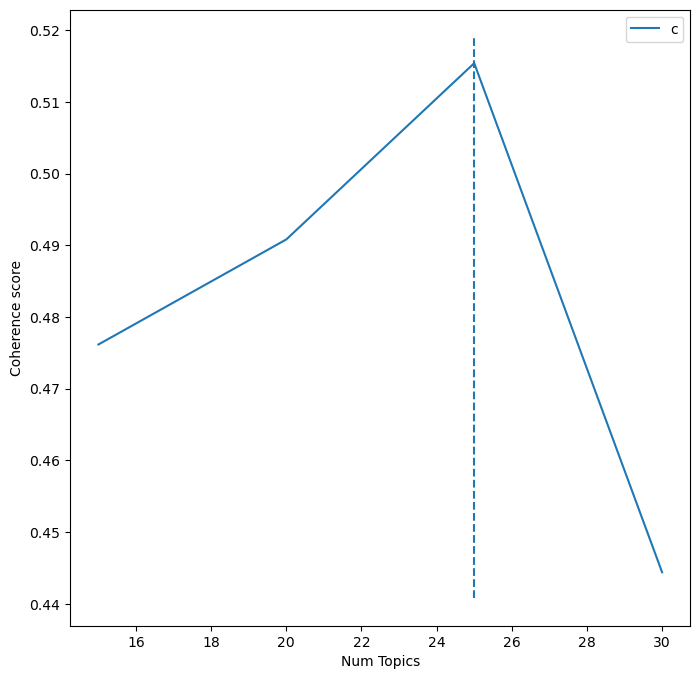

Num Topics = 15  has a Coherence Value of 0.4762
Num Topics = 20  has a Coherence Value of 0.4908
Num Topics = 25  has a Coherence Value of 0.5154
Num Topics = 30  has a Coherence Value of 0.4444


In [13]:
checkCoherence(coherenceValues)

In [14]:
# save models as pickle file
with open('LDA_modelList_15_30_by_5.pkl', 'wb') as file:
    pickle.dump(modelList, file)

with open('LDA_modelList_15_30_by_5.pkl', 'rb') as file:
    lda = pickle.load(file)

In [ ]:
# save models as pickle file
with open('LDA_modelList_15_30_by_5.pkl', 'wb') as file:
    pickle.dump(modelList, file)

In [16]:
lda

In [15]:
for model in modelList:
    showWordsPerTopic(model, 20)
    print('\n')

Topic 0: mens, gebied, land, stad, leven, groot, water, treffen, militair, liggen, huis, melden, kilo_meter, regio, zwaar, dood, vallen, raken, schade, eiland
Topic 1: china, land, chinees, vs, rusland, amerikaans, president, peking, taiwan, poetin, taliban, bezoek, verenigde, xi, groot, russisch, staten, militair, navo, nieuw
Topic 2: duitsland, duits, schip, frans, frankrijk, europees, nederland, macron, europa, polen, gas, migranten, migrant, zee, land, italië, boot, pools, russisch, procent
Topic 3: groot, nieuw, mens, leven, krijgen, keer, aarde, tijd, goed, jaar, vrouw, zitten, weten, blijven, russisch, klein, kilo_meter, australisch, wereld, heel
Topic 4: premier, partij, brits, europees, parlement, commissie, eu, europese, nieuw, regering, johnson, plan, krijgen, minister, land, verenigd, koninkrijk, brussel, groot, politiek
Topic 5: mens, protest, politie, stad, straat, demonstrant, groot, brand, demonstratie, vandaag, demonstreren, land, krijgen, navalny, regering, agent, bli